# What this notebook does

### Title: LLM-scCurator Quickstart (Python, Local feature distillation → Policy-Friendly LLM Annotation)

This notebook is a minimal end-to-end demo of LLM-scCurator in a local environment using Jupyter.

Using the public PBMC3k (Scanpy) dataset, we:

1. Load, QC, normalize/log-transform the data, run PCA/UMAP, and cluster cells in Python (Scanpy).
2. Generate cluster markers (DE genes) and apply LLM-scCurator’s noise masking / feature distillation to produce a curated marker list per cluster.
3. Export a curated marker list per cluster →genes table (CSV) for manual, chat-based annotation with an institution-approved LLM (e.g., Microsoft Copilot “Work”), by referencing an exported table (no external LLM API calls).
4. (Optional) Annotate the exported CSV using Copilot “Work” with the provided prompt, and save the returned annotated CSV.

Core requirement:
- LLM-scCurator expects log1p-normalized expression in `adata.X`.
- Keep raw counts in `adata.layers["counts"]`.


## Install Python packages + LLM-scCurator

### Option A (recommended): Run inside the provided Docker image
No manual installation is required. The Docker image already includes **LLM-scCurator** and all dependencies.

---

### Option B: Run outside Docker (local Python environment)

#### B-1) Install from PyPI
```bash
    %pip -q install llm-sc-curator

```
#### B-2) Install from source (latest / development)
    
```bash
    # 1) Clone the repository
    %git clone https://github.com/kenflab/LLM-scCurator.git
    %cd LLM-scCurator
    
    # 2) Install the package (and dependencies)
    %pip -q install .
 ```

## Imports + reproducibility

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import random, os

import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

from llm_sc_curator import (
    export_cluster_annotation_table,
    apply_cluster_map_to_cells,
    harmonize_labels,
)

%matplotlib inline
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


## Data input: Scanpy demo PBMC3k

In [2]:
# Load demo data
adata = sc.datasets.pbmc3k()

# Minimal QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

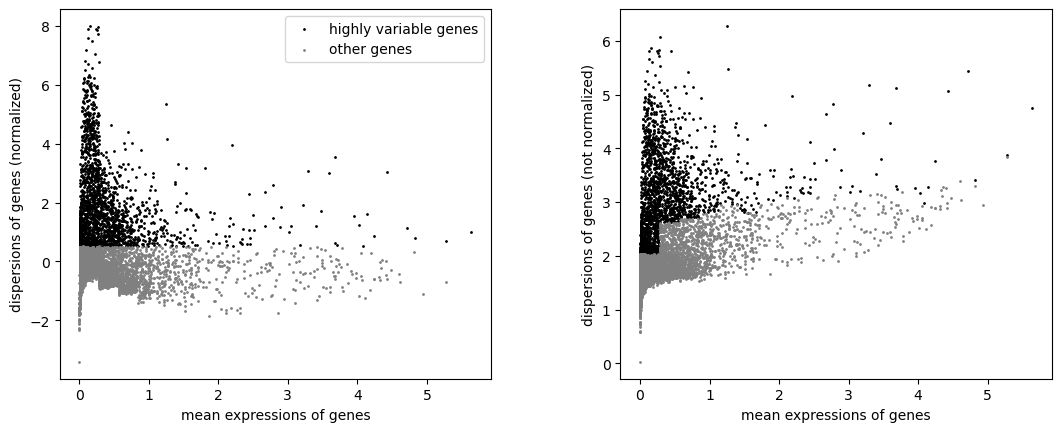

In [3]:
# Save raw counts, then normalize/log1p into .X (required by LLM-scCurator)
adata.layers["counts"] = adata.X.copy()

# Normalize + log1p (standard)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat",
    subset=False,
)
sc.pl.highly_variable_genes(adata)

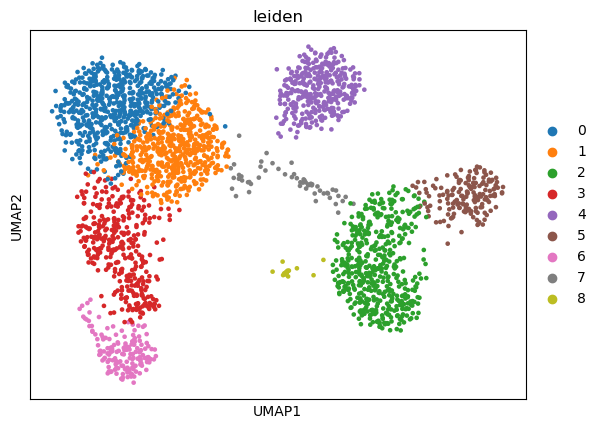

In [4]:
# PCA/Neighbors/UMAP/Leiden using HVGs
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])


##  Run LLM-scCurator, noise masking and Gini-informed distillation

**Notes:**
> We provide OllamaBackend because LLMscCurator expects a backend during initialization. Adaptive feature distillation (curation/masking) runs purely on adata and does not call the backend unless you later run annotation.

In [5]:
# Curator Initialize
from llm_sc_curator.backends import OllamaBackend
backend = OllamaBackend()

curator = LLMscCurator(backend=backend)
curator.set_global_context(adata)

In [6]:
# CONFIG
cluster_col = "leiden"
out_csv = "cluster_curated_map.csv"
prefix = "Curated"

In [7]:
clusters = sorted(adata.obs[cluster_col].astype(str).unique())

cluster_results = {}
genes_by_cluster = {}

for cl in clusters:
    genes = curator.curate_features(adata, group_col=cluster_col, target_group=str(cl))
    genes_by_cluster[str(cl)] = genes or []

    cluster_results[str(cl)] = {
        "cell_type": "",
        "confidence": "",
        "reasoning": "",
    }

In [8]:
# EXPORT TABLE (v0.1.1+)
df_cluster = export_cluster_annotation_table(
    adata,
    cluster_col=cluster_col,
    cluster_results=cluster_results,
    genes_by_cluster=genes_by_cluster,
    prefix=prefix,
)

df_cluster.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"Wrote {out_csv}")

df_cluster

Wrote cluster_curated_map.csv


,leiden,n_cells,Curated_CellType,Curated_Confidence,Curated_Reasoning,Curated_Genes
0,0,582,,Low,,CD3D;CD3E;SRSF5;SELL;LTB;MAL;HINT1;GIMAP5;TRAF...
1,1,536,,Low,,LTB;IL32;CD3D;CD3E;GIMAP7;CD2;AQP3;HINT1;GIMAP...
2,2,489,,Low,,LYZ;S100A9;S100A8;TYROBP;FCN1;CST3;LGALS2;S100...
3,3,355,,Low,,CCL5;NKG7;IL32;GZMA;CTSW;CST7;GZMK;CD3D;PTPRCA...
4,4,348,,Low,,CD74;HLA-DRA;CD79A;CD79B;HLA-DPB1;MS4A1;HLA-DQ...
5,5,162,,Low,,LST1;FCER1G;AIF1;COTL1;FCGR3A;IFITM3;SAT1;CTSS...
6,6,158,,Low,,NKG7;GNLY;GZMB;CTSW;PRF1;CST7;GZMA;FGFBP2;CD24...
7,7,54,,Low,,HLA-DRB1;CD74;HLA-DRA;HLA-DPB1;HLA-DQB1;HLA-DQ...
8,8,16,,Low,,PPBP;GPX1;SDPR;PF4;NRGN;OAZ1;CCL5;GNG11;SPARC;...


### (Optinal) Copilot “Work” prompt (paste as-is)

Upload `cluster_curated_map.csv` to Copilot “Work”, then paste the following prompt:

```text
Role: Expert in single-cell transcriptomics.
Task:
Annotate uploaded CSV. 
Identify the SINGLE BEST cell lineage/subtype based on markers.
Fill Curated_CellType, Curated_Confidence, and Curated_Reasoning from Curated_Genes, and return both the annotated CSV file.


In [9]:
prompt_path = out_csv.replace(".csv", ".prompt.txt") 
prompt_text = """Role: Expert in single-cell transcriptomics.
Task:
Annotate uploaded CSV.
Identify the SINGLE BEST cell lineage/subtype based on markers.
Fill Curated_CellType, Curated_Confidence, and Curated_Reasoning from Curated_Genes, and return both the annotated CSV file.
"""

print(f"Wrote {prompt_path}")
print()
print(f"Next: Upload '{out_csv}' to Copilot “Work”, then paste the prompt below (or upload '{prompt_path}').")
print("-" * 60)
print(prompt_text)


Wrote cluster_curated_map.prompt.txt

Next: Upload 'cluster_curated_map.csv' to Copilot “Work”, then paste the prompt below (or upload 'cluster_curated_map.prompt.txt').
------------------------------------------------------------
Role: Expert in single-cell transcriptomics.
Task:
Annotate uploaded CSV.
Identify the SINGLE BEST cell lineage/subtype based on markers.
Fill Curated_CellType, Curated_Confidence, and Curated_Reasoning from Curated_Genes, and return both the annotated CSV file.



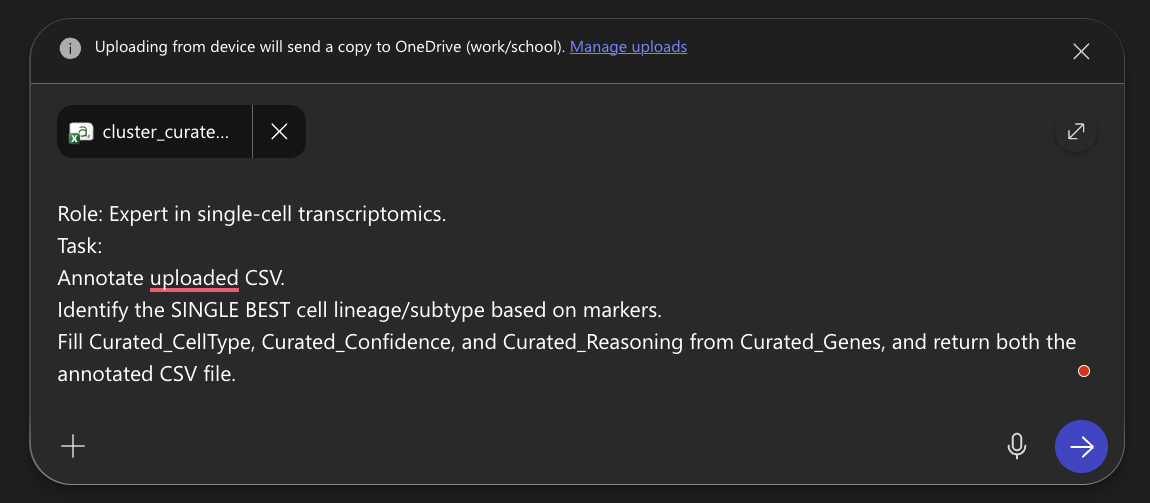

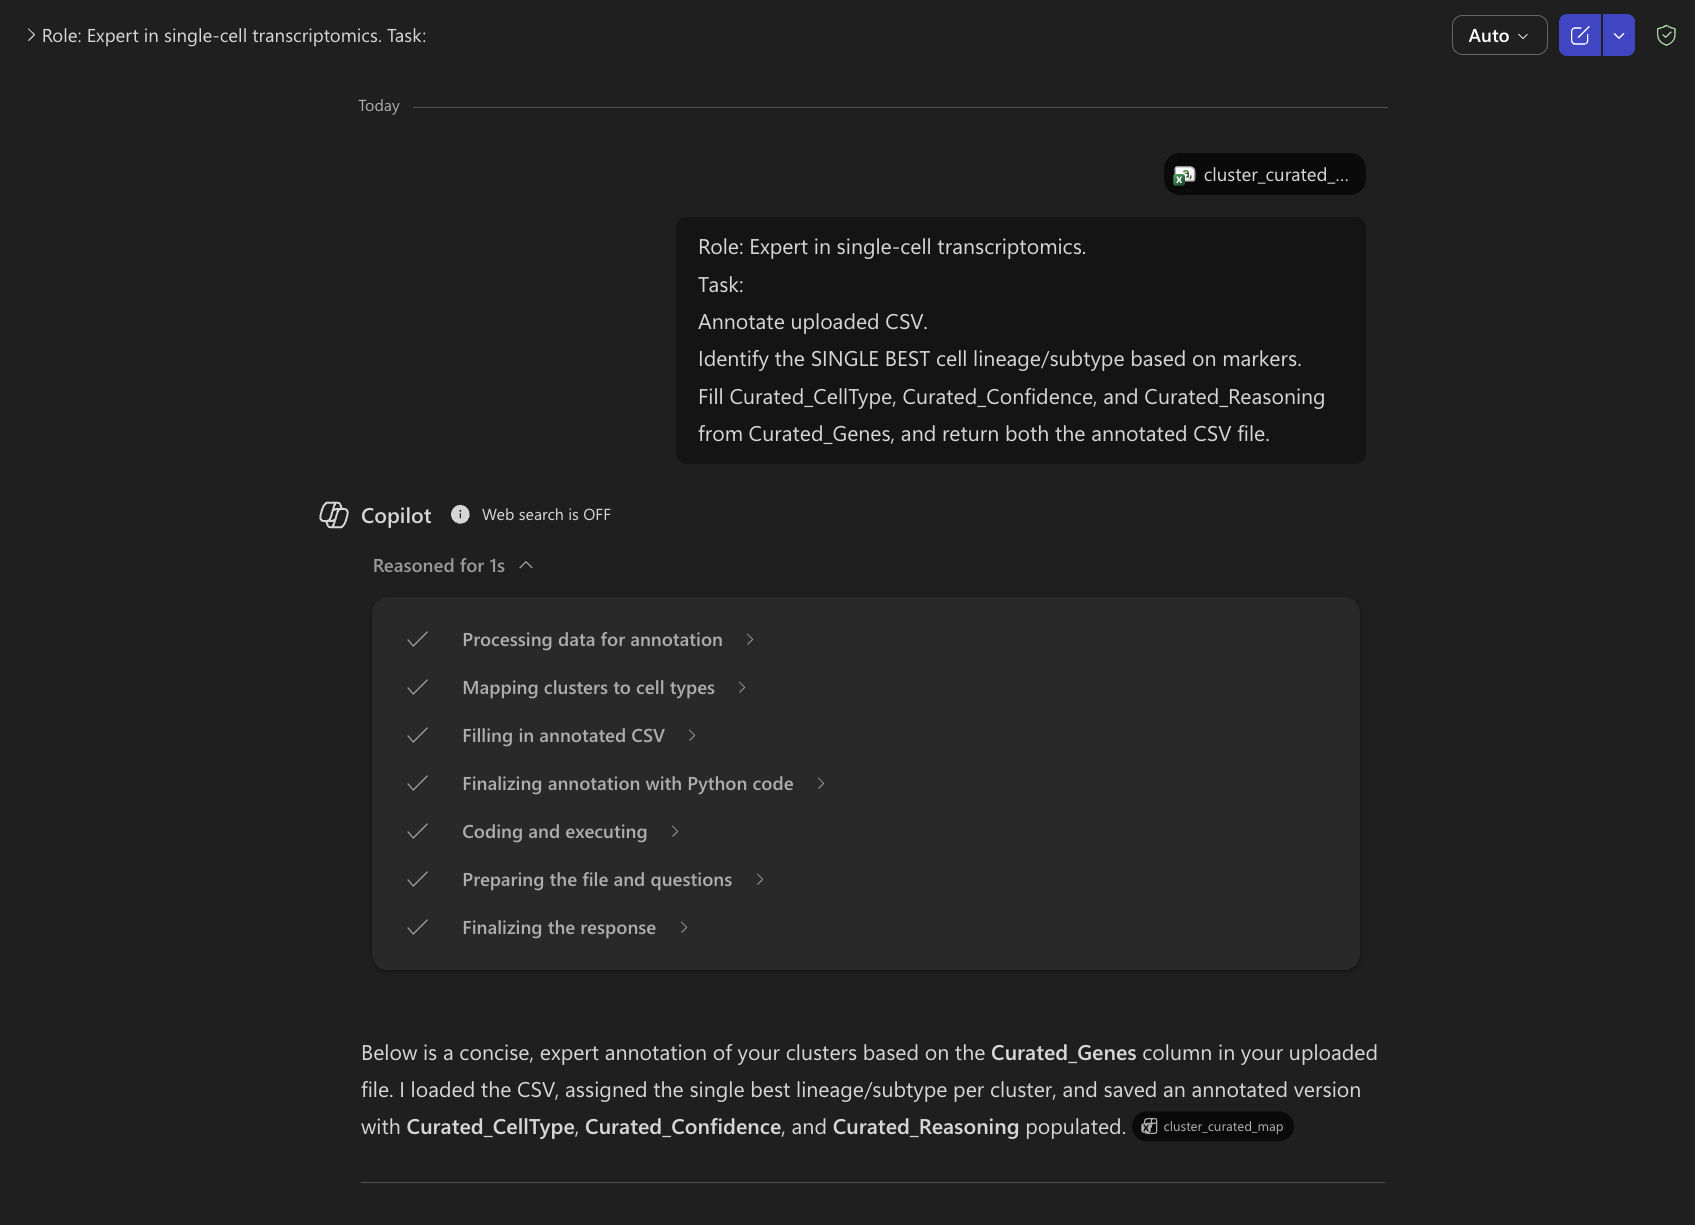

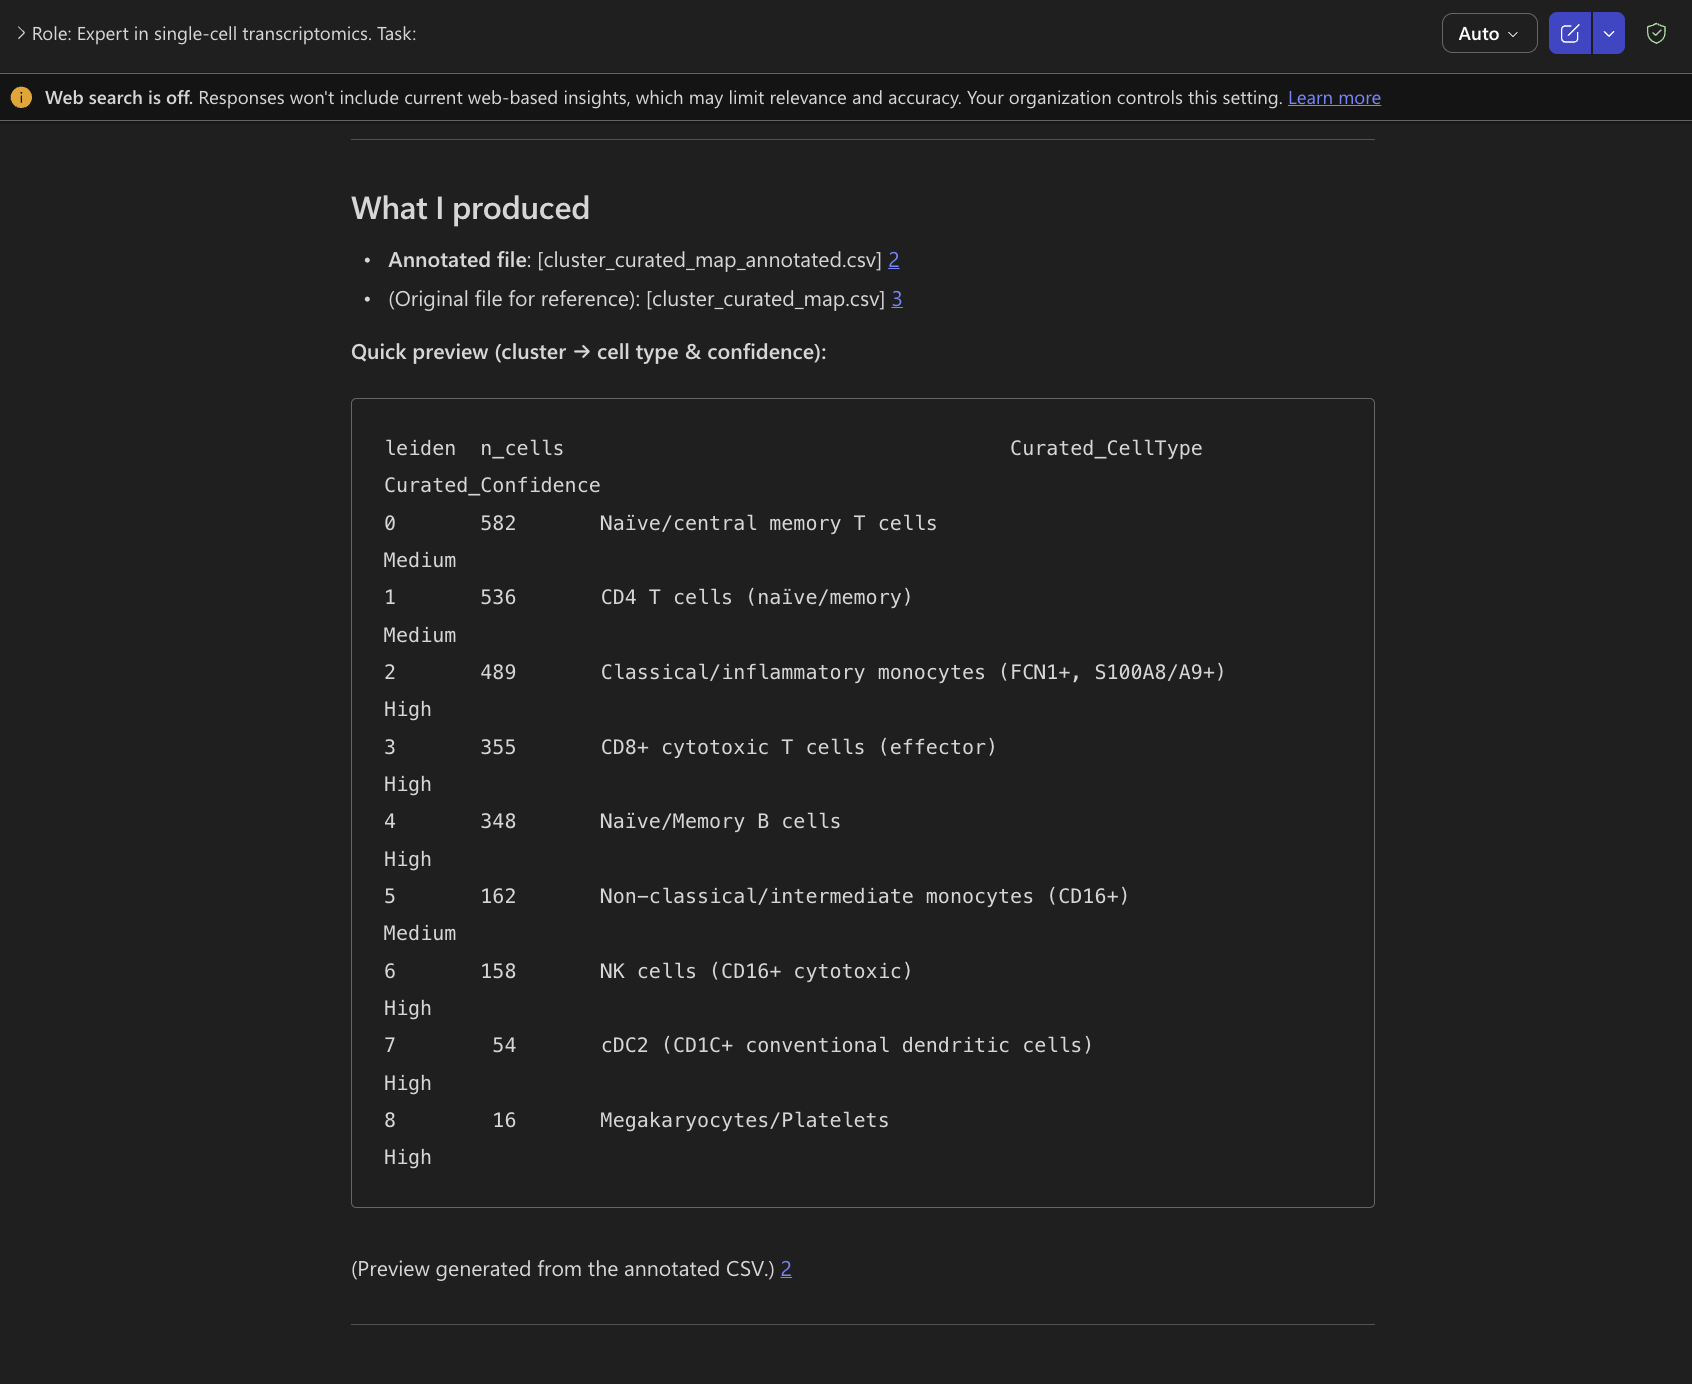

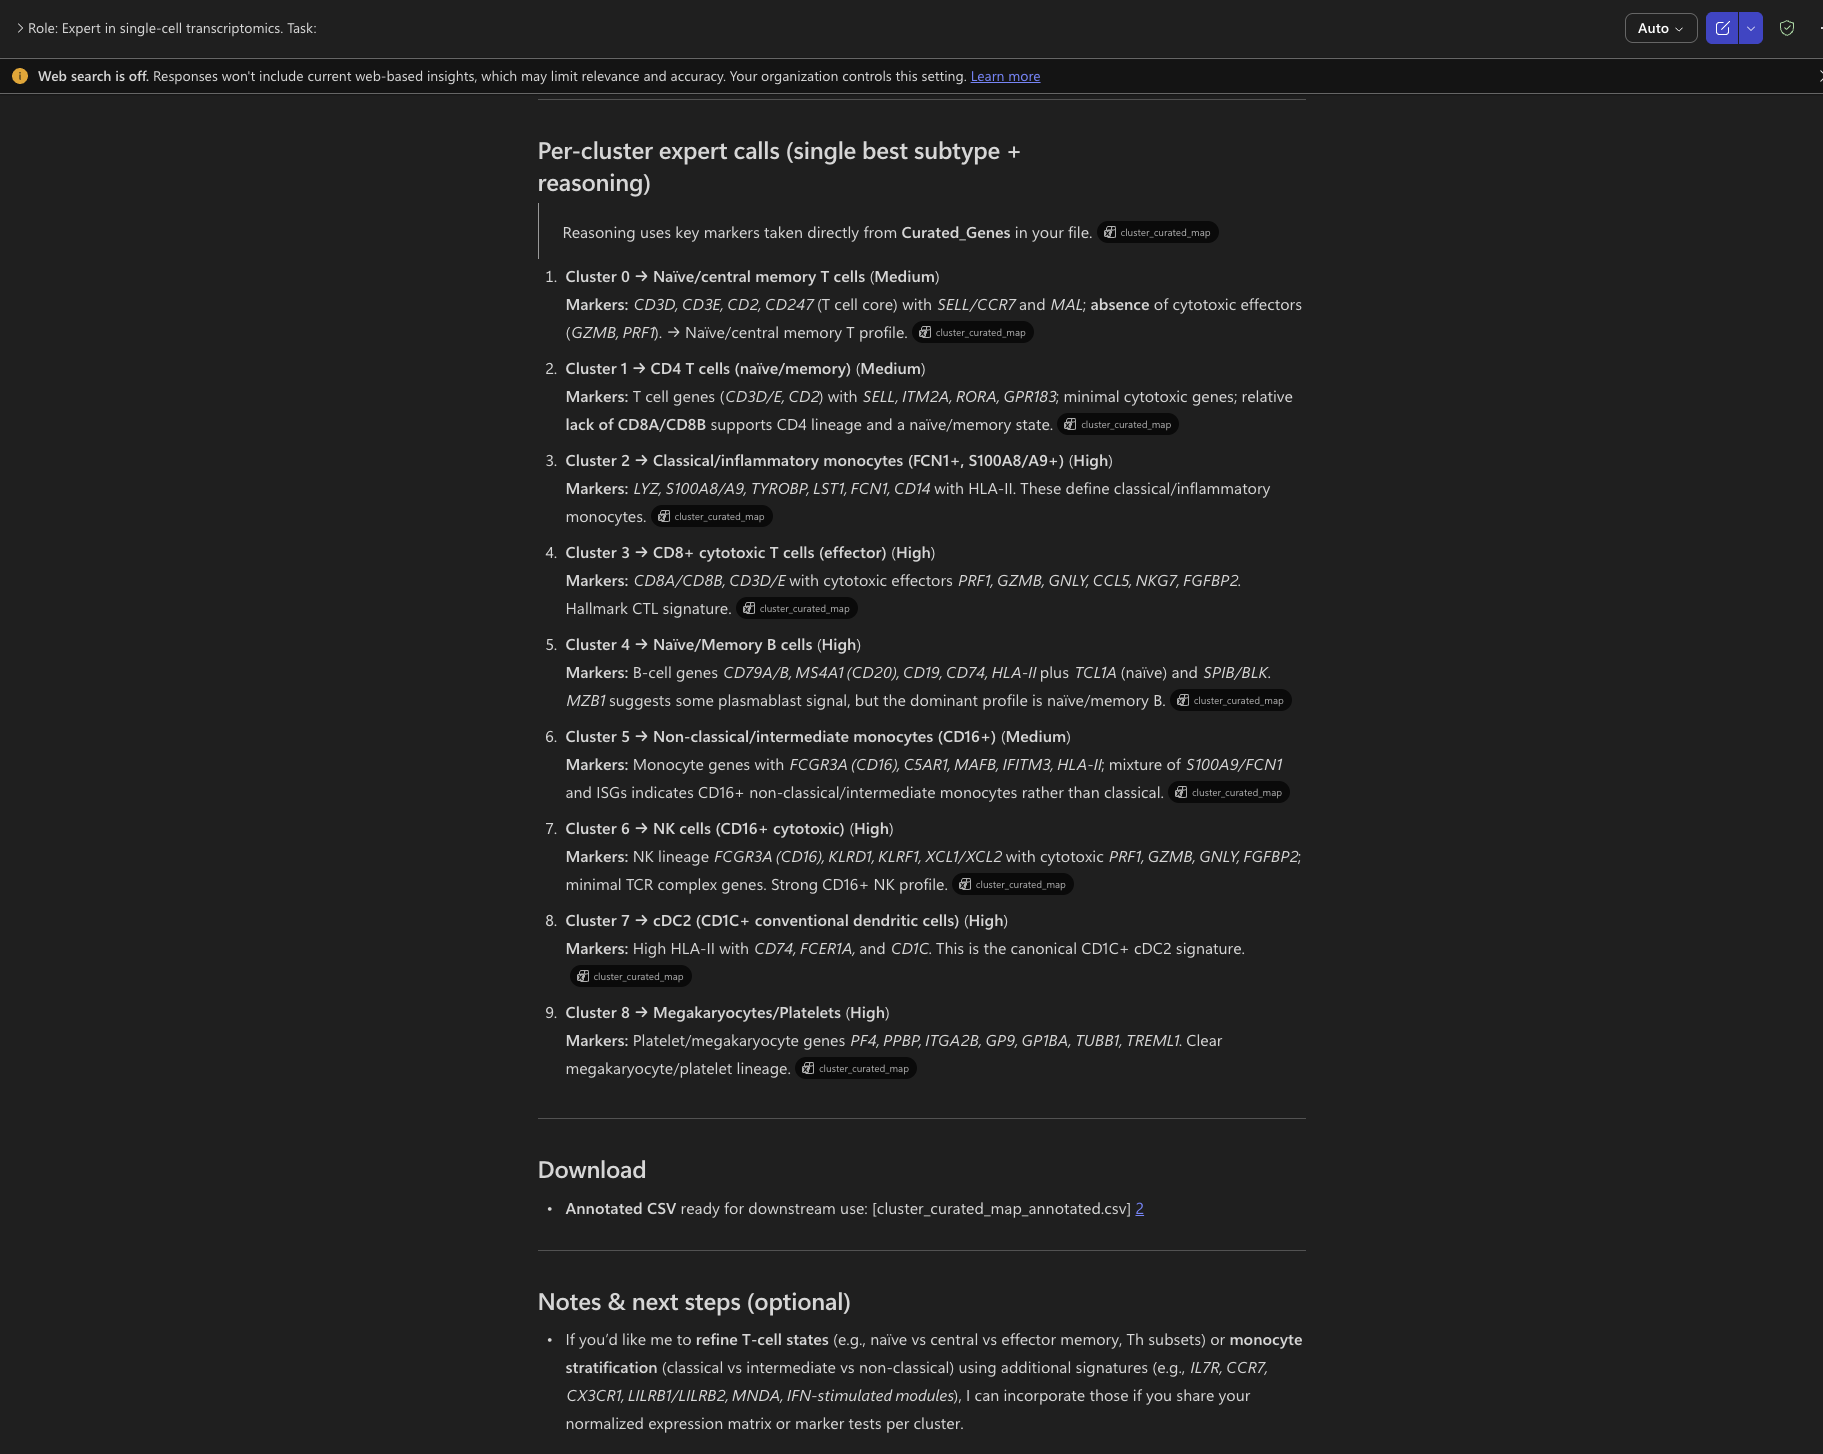

In [10]:
df_cluster_annotated = pd.read_csv("cluster_curated_map_annotated.csv")
df_cluster_annotated

,leiden,n_cells,Curated_CellType,Curated_Confidence,Curated_Reasoning,Curated_Genes
0,0,582,Naïve/central memory T cells,Medium,"T cell markers (CD3D, CD3E, CD2, CD247) with C...",CD3D;CD3E;SRSF5;SELL;LTB;MAL;HINT1;GIMAP5;TRAF...
1,1,536,CD4 T cells (naïve/memory),Medium,"T cell markers (CD3D/E, CD2) with SELL, ITM2A,...",LTB;IL32;CD3D;CD3E;GIMAP7;CD2;AQP3;HINT1;GIMAP...
2,2,489,"Classical/inflammatory monocytes (FCN1+, S100A...",High,"Myeloid/monocyte markers LYZ, S100A8/A9, TYROB...",LYZ;S100A9;S100A8;TYROBP;FCN1;CST3;LGALS2;S100...
3,3,355,CD8+ cytotoxic T cells (effector),High,"CD8 lineage (CD8A/CD8B, CD3D/E) with cytotoxic...",CCL5;NKG7;IL32;GZMA;CTSW;CST7;GZMK;CD3D;PTPRCA...
4,4,348,Naïve/Memory B cells,High,"B-cell markers CD79A/B, MS4A1 (CD20), CD19, CD...",CD74;HLA-DRA;CD79A;CD79B;HLA-DPB1;MS4A1;HLA-DQ...
5,5,162,Non-classical/intermediate monocytes (CD16+),Medium,"Monocyte markers with FCGR3A (CD16), C5AR1, MA...",LST1;FCER1G;AIF1;COTL1;FCGR3A;IFITM3;SAT1;CTSS...
6,6,158,NK cells (CD16+ cytotoxic),High,"NK lineage markers FCGR3A (CD16), KLRD1, KLRF1...",NKG7;GNLY;GZMB;CTSW;PRF1;CST7;GZMA;FGFBP2;CD24...
7,7,54,cDC2 (CD1C+ conventional dendritic cells),High,"High HLA-II with CD74, FCER1A and CD1C is hall...",HLA-DRB1;CD74;HLA-DRA;HLA-DPB1;HLA-DQB1;HLA-DQ...
8,8,16,Megakaryocytes/Platelets,High,"Platelet/megakaryocyte genes PF4, PPBP, ITGA2B...",PPBP;GPX1;SDPR;PF4;NRGN;OAZ1;CCL5;GNG11;SPARC;...


In [11]:
# PER-CELL LABEL
apply_cluster_map_to_cells(
    adata,
    cluster_col=cluster_col,
    df_cluster=df_cluster_annotated,
    label_col=f"{prefix}_CellType",
    new_col=f"{prefix}_CellType",
)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'leiden', 'Curated_CellType'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

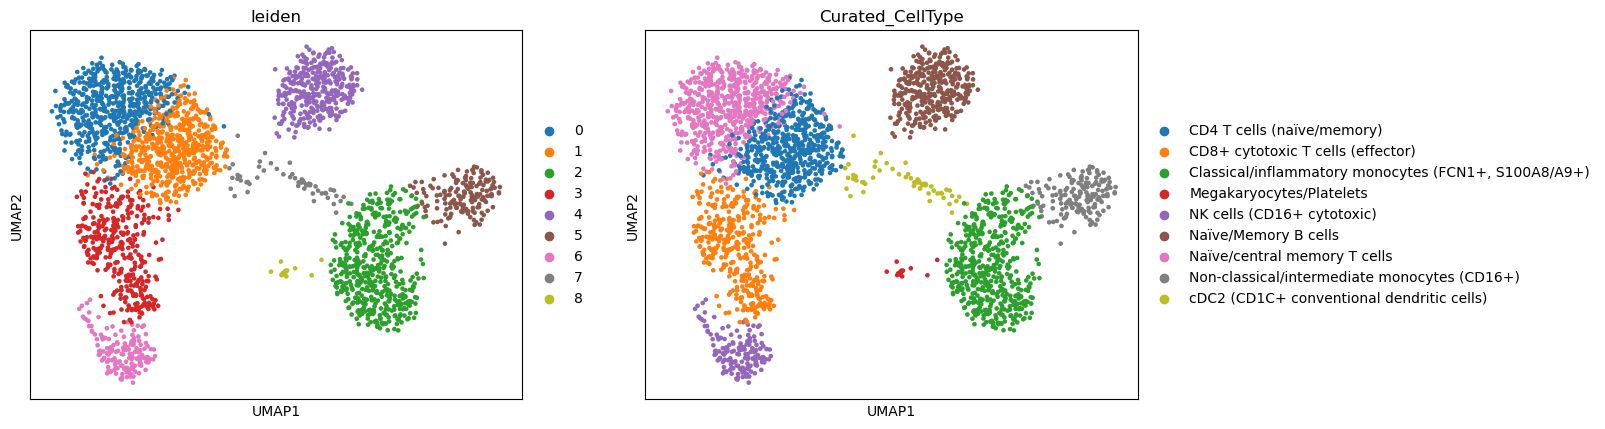

In [12]:
sc.pl.umap(adata, color=["leiden", f"{prefix}_CellType"])


## Quick marker dotplots for sanity-checking labels

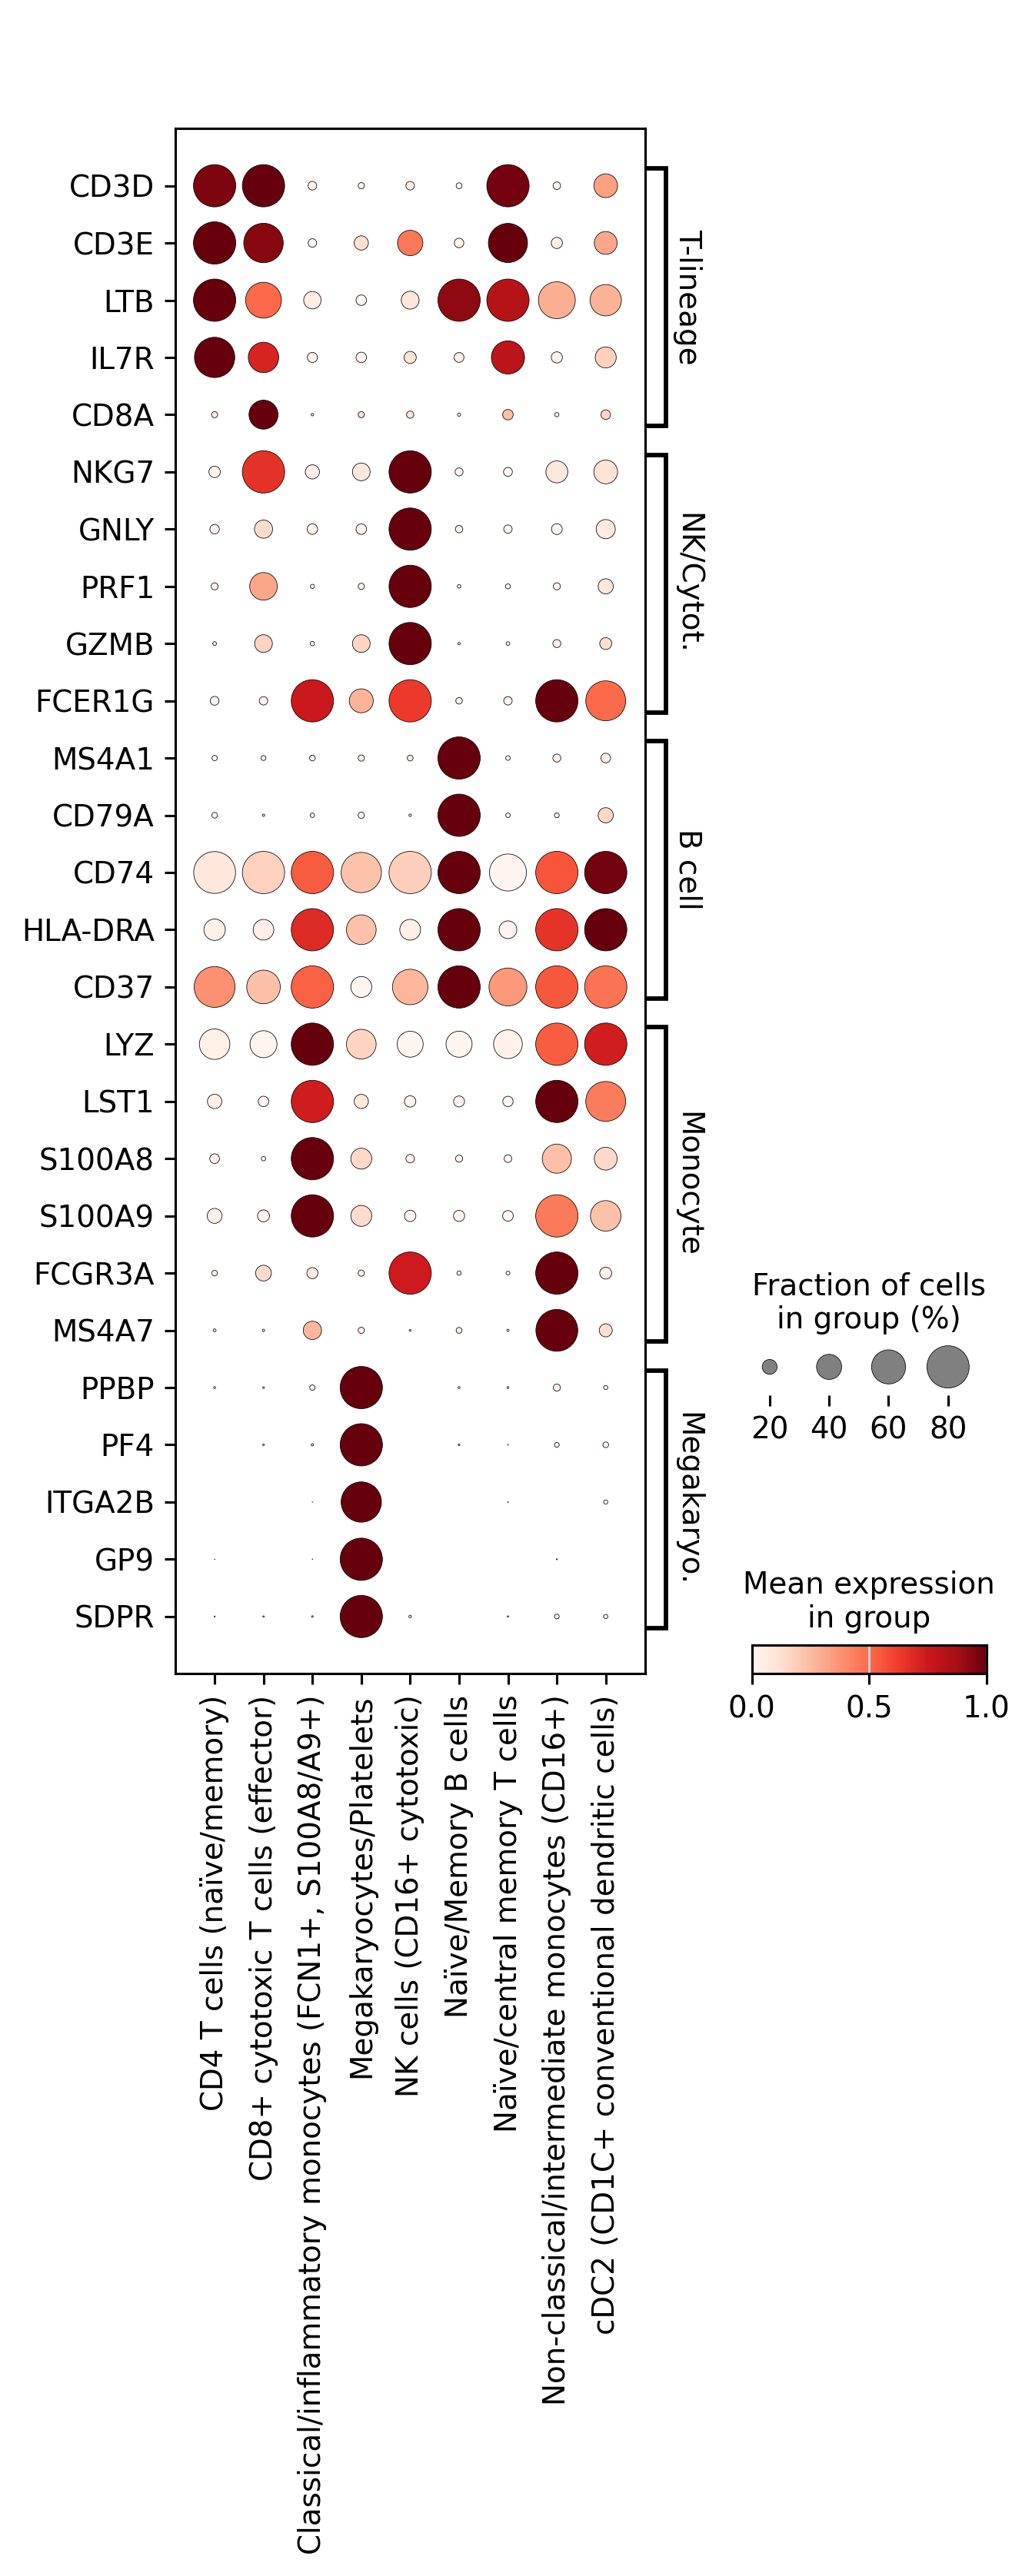

In [13]:
sc.set_figure_params(dpi=140, fontsize=12)

# ---------- marker panels (canonical) ----------
MARKERS_MAJOR = {
    "T-lineage":       ["TRAC", "CD3D", "CD3E", "LTB", "IL7R", "CD8A"],
    "NK/Cytotoxic":    ["NKG7", "GNLY", "PRF1", "GZMB", "FCER1G"],
    "B cell":          ["MS4A1", "CD79A", "CD74", "HLA-DRA", "CD37"],
    "Monocyte":        ["LYZ", "LST1", "S100A8", "S100A9", "FCGR3A", "MS4A7"],
    "Megakaryocyte":   ["PPBP", "PF4", "ITGA2B", "GP9", "SDPR"],
}

# ---------- Utility: drop genes not present + dedupe across groups ----------
def filter_and_dedupe_markers(marker_dict, var_names):
    vset = set(map(str, var_names))
    used = set()
    out = {}
    for group, genes in marker_dict.items():
        cleaned = []
        for g in genes:
            g = str(g)
            if g not in vset:
                continue
            if g in used:
                continue
            cleaned.append(g)
            used.add(g)
        if cleaned:
            out[group] = cleaned
    return out

# Major type dotplot
markers = filter_and_dedupe_markers(MARKERS_MAJOR, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="Curated_CellType",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)





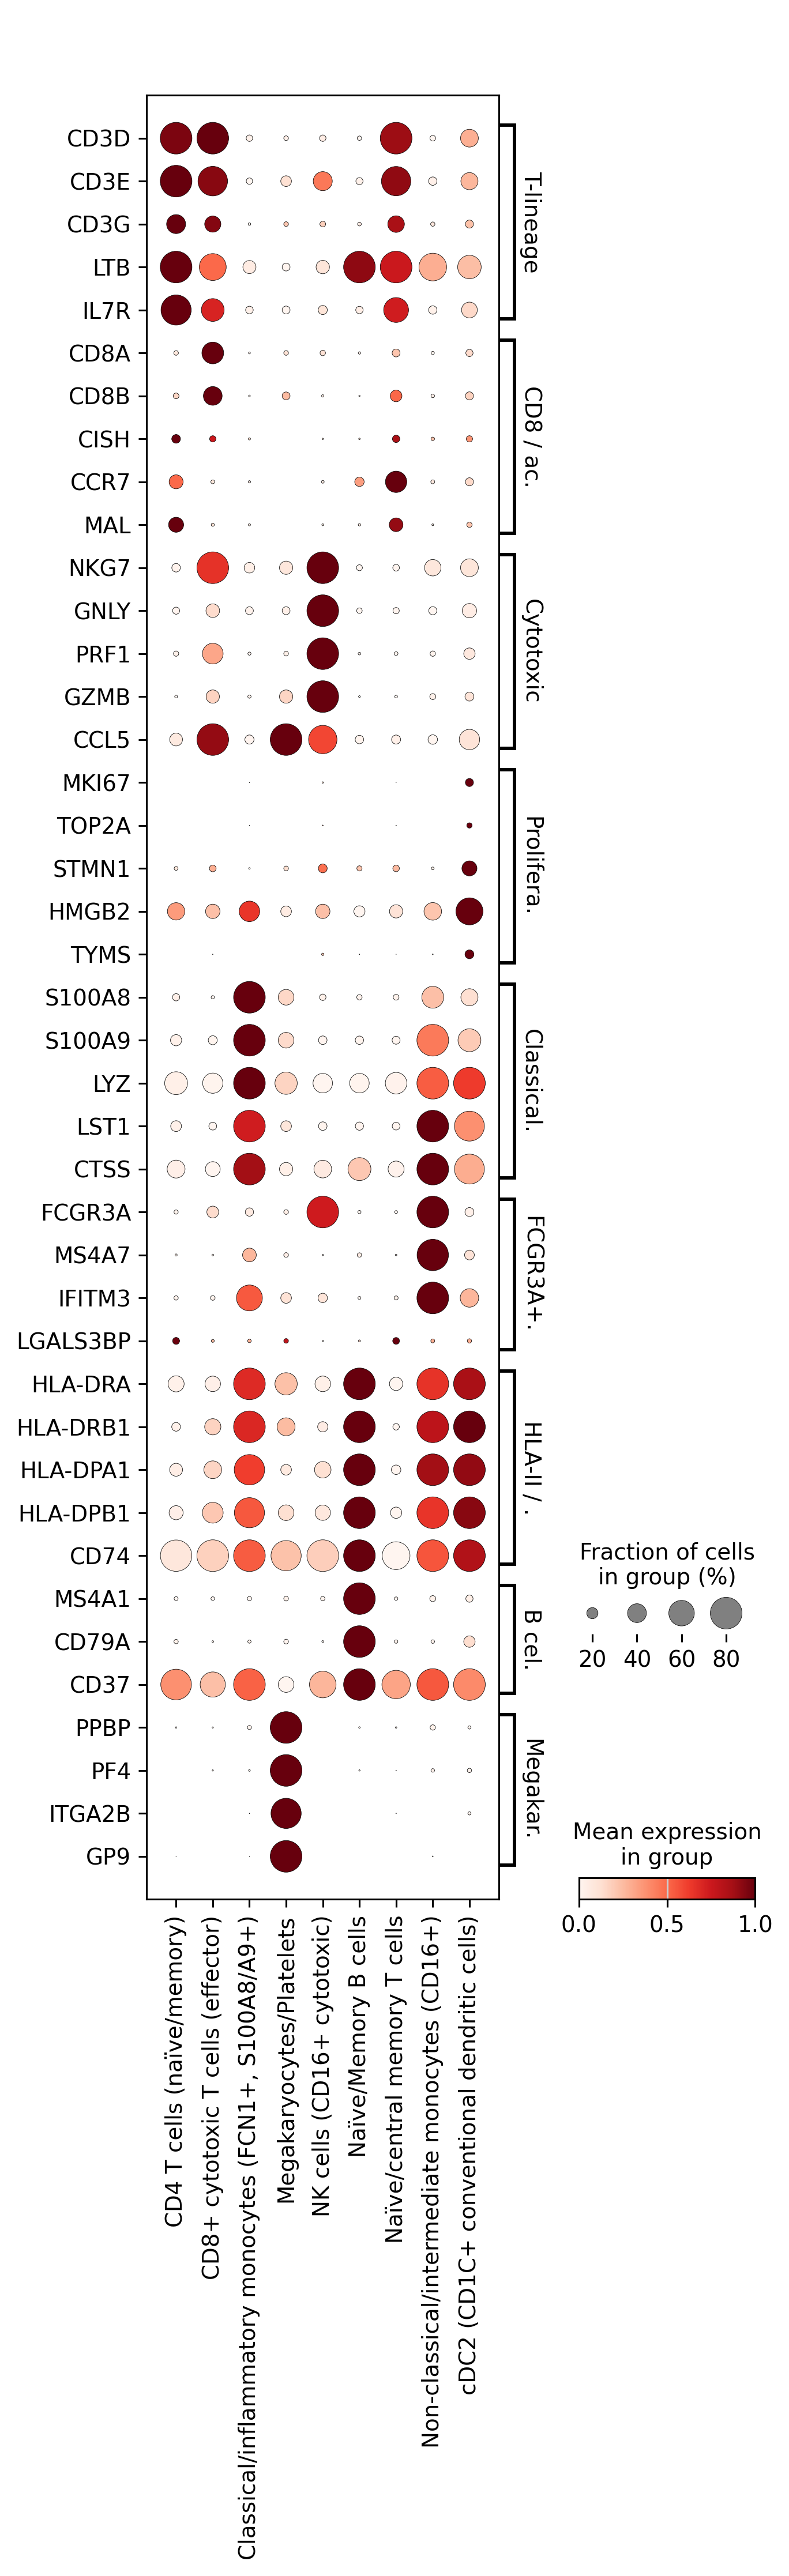

In [14]:
MARKERS_FINE = {
    "T-lineage":         ["TRAC", "CD3D", "CD3E", "CD3G", "LTB", "IL7R"],
    "CD8 / activation":  ["CD8A", "CD8B", "CISH", "CCR7", "MAL"],
    "Cytotoxic":         ["NKG7", "GNLY", "PRF1", "GZMB", "CCL5"],
    "Proliferation":     ["MKI67", "TOP2A", "STMN1", "HMGB2", "TYMS"],
    "Classical mono":    ["S100A8", "S100A9", "LYZ", "LST1", "CTSS"],
    "FCGR3A+ mono":      ["FCGR3A", "MS4A7", "IFITM3", "LGALS3BP"],
    "HLA-II / APC":      ["HLA-DRA", "HLA-DRB1", "HLA-DPA1", "HLA-DPB1", "CD74"],
    "B cell":            ["MS4A1", "CD79A", "CD74", "CD37"],
    "Megakaryocyte":     ["PPBP", "PF4", "ITGA2B", "GP9"],
}


# ---------- Plot settings ----------
markers = filter_and_dedupe_markers(MARKERS_FINE, adata.var_names)
sc.pl.dotplot(
    adata,
    markers,
    groupby="Curated_CellType",
    standard_scale="var",
    use_raw=False,
    swap_axes=True,
    dot_min=0.0,
    dot_max=0.8,
    show=True,
)


In [15]:
df_cluster_annotated[df_cluster_annotated["Curated_Confidence"].str.lower() == "medium"][
    ["leiden","n_cells","Curated_CellType","Curated_Genes"]
]

,leiden,n_cells,Curated_CellType,Curated_Genes
0,0,582,Naïve/central memory T cells,CD3D;CD3E;SRSF5;SELL;LTB;MAL;HINT1;GIMAP5;TRAF...
1,1,536,CD4 T cells (naïve/memory),LTB;IL32;CD3D;CD3E;GIMAP7;CD2;AQP3;HINT1;GIMAP...
5,5,162,Non-classical/intermediate monocytes (CD16+),LST1;FCER1G;AIF1;COTL1;FCGR3A;IFITM3;SAT1;CTSS...


In [16]:
# ---- OPTIONAL: LABEL HARMONIZATION ----
label_map = {
    "Naïve/central memory T cells": "CD4 Naive/CM T",
    "CD4 T cells (naïve/memory)": "CD4 Naive/Memory T",
    "Classical/inflammatory monocytes (FCN1+, S100A8/A9+)": "Classical monocytes (FCN1+ S100A8/A9+)",
    "Non-classical/intermediate monocytes (CD16+)": "CD16+ monocytes (FCGR3A+)",
    # optional:
    "cDC2 (CD1C+ conventional dendritic cells)": "CD1C+ cDC (cDC2)",
}


if label_map:
    adata = harmonize_labels(
        adata,
        col=f"{prefix}_CellType",
        mapping=label_map,
        new_col=f"{prefix}_CellType_harmonized",
        keep_raw=True,
    )
    out_csv2 = out_csv.replace(".csv", "_harmonized.csv")
    df_cluster2 = df_cluster_annotated.copy()
    df_cluster2[f"{prefix}_CellType"] = df_cluster2[f"{prefix}_CellType"].replace(label_map)
    df_cluster2.to_csv(out_csv2, index=False)
    print(f"Wrote {out_csv2}")

# ---- QUICK CHECK ----
df_cluster2[[cluster_col, "n_cells", f"{prefix}_CellType", f"{prefix}_Confidence"]]

Wrote cluster_curated_map_harmonized.csv


,leiden,n_cells,Curated_CellType,Curated_Confidence
0,0,582,CD4 Naive/CM T,Medium
1,1,536,CD4 Naive/Memory T,Medium
2,2,489,Classical monocytes (FCN1+ S100A8/A9+),High
3,3,355,CD8+ cytotoxic T cells (effector),High
4,4,348,Naïve/Memory B cells,High
5,5,162,CD16+ monocytes (FCGR3A+),Medium
6,6,158,NK cells (CD16+ cytotoxic),High
7,7,54,CD1C+ cDC (cDC2),High
8,8,16,Megakaryocytes/Platelets,High


In [17]:
# PER-CELL LABEL
apply_cluster_map_to_cells(
    adata,
    cluster_col=cluster_col,
    df_cluster=df_cluster2,
    label_col=f"{prefix}_CellType",
    new_col=f"{prefix}_CellType_harmonized",
)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'leiden', 'Curated_CellType', 'Curated_CellType_raw', 'Curated_CellType_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Curated_CellType_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

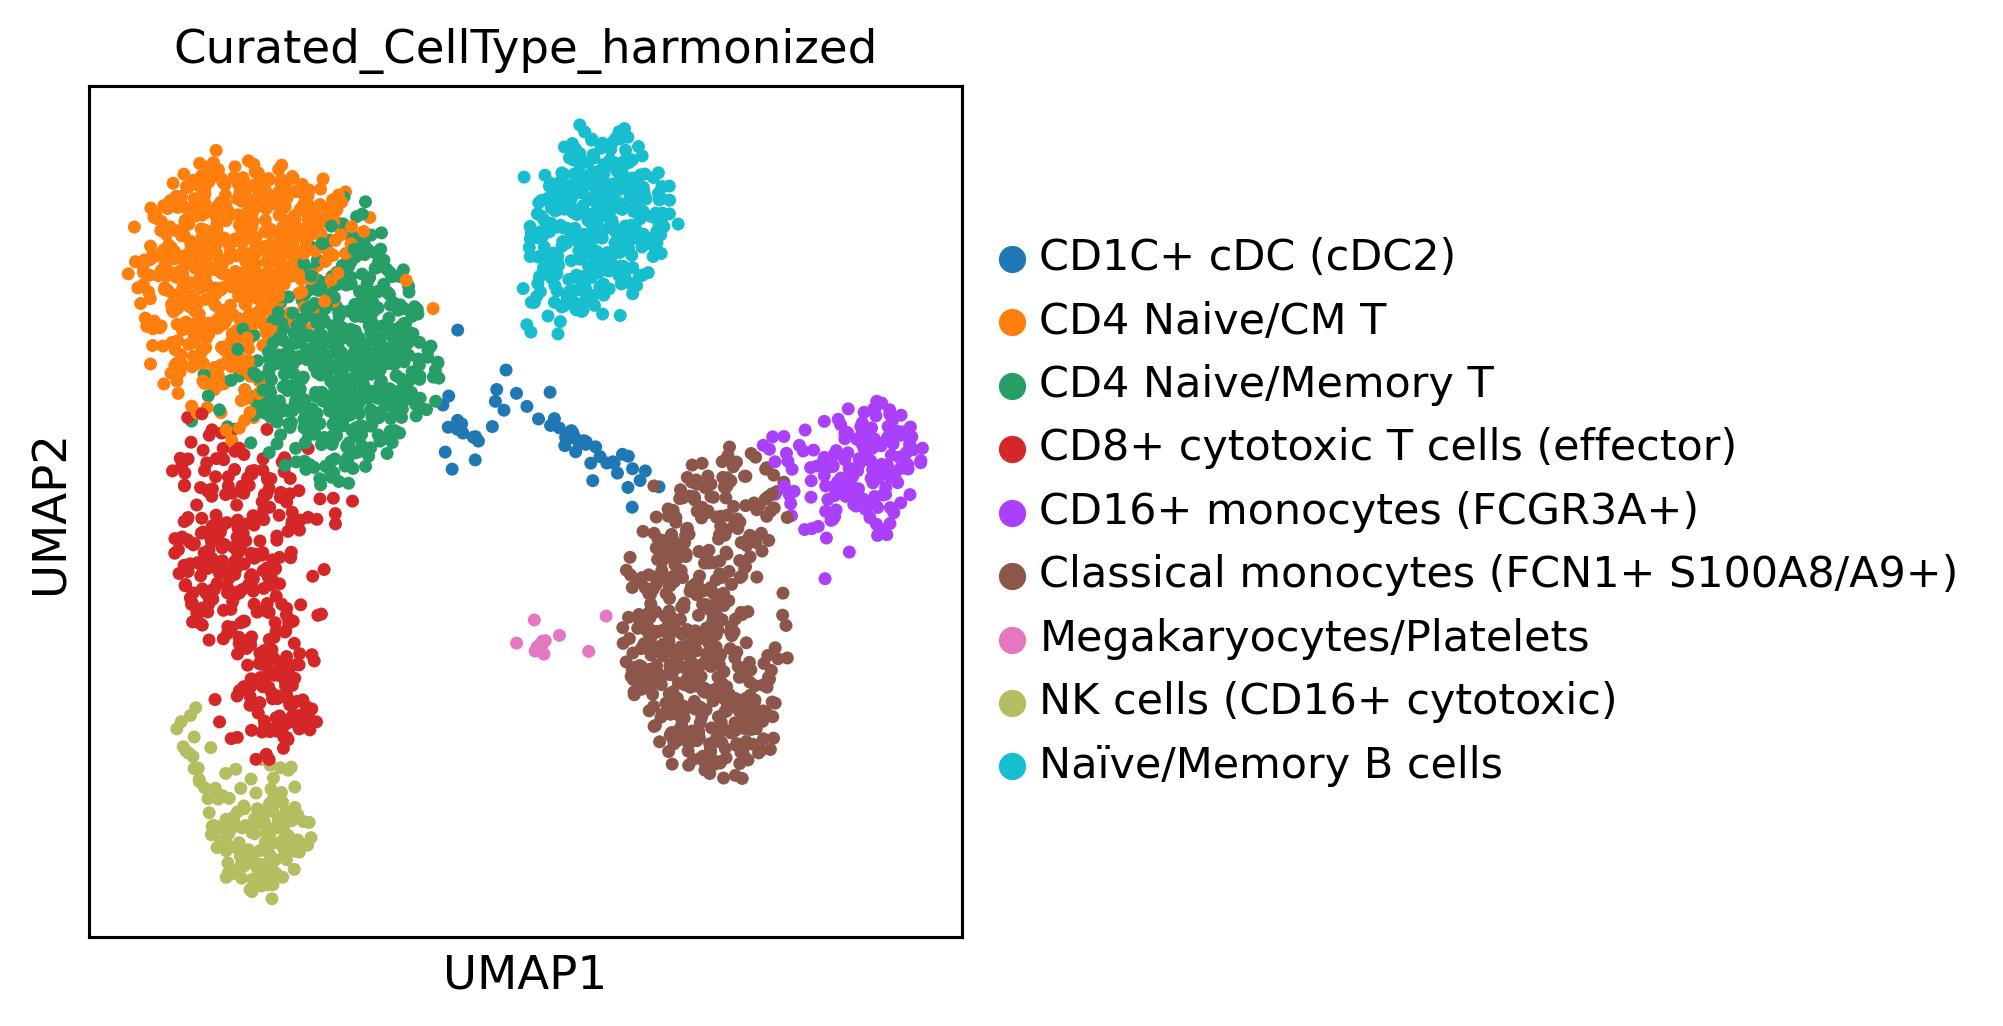

In [18]:
sc.pl.umap(adata, color=[f"{prefix}_CellType_harmonized"])
